In [1]:
import pandas as pd

df = pd.DataFrame({
    'team':['Germany','USA','France','Japan','Sweden','England','Brazil','Canada','Australia','Norway','Netherlands','Spain',
           'China','New Zealand','South Korea','Switzerland','Mexico','Colombia','Thailand','Nigeria','Ecuador','Ivory Coast','Cameroon','Costa Rica'],
    'group':['B','D','F','C','D','F','E','A','D','B','A','E','A','A','E','C','F','F','B','D','C','B','C','E'],
    'fifascore':[2168,2158,2103,2066,2008,2001,1984,1969,1968,1933,1919,1867,1847,1832,1830,1813,1748,1692,1651,1633,1485,1373,1455,1589],
    'ftescore':[95.6,95.4,92.4,92.7,91.6,89.6,92.2,90.1,88.7,88.7,86.2,84.7,85.2,82.5,84.3,83.7,81.1,78.0,68.0,85.7,63.3,75.6,79.3,72.8]
    })

df.groupby(['group', 'team']).mean()

fifascore  ftescore
group team                            
A     Canada            1969      90.1
      China             1847      85.2
      Netherlands       1919      86.2
      New Zealand       1832      82.5
B     Germany           2168      95.6
      Ivory Coast       1373      75.6
      Norway            1933      88.7
      Thailand          1651      68.0
C     Cameroon          1455      79.3
      Ecuador           1485      63.3
      Japan             2066      92.7
      Switzerland       1813      83.7
D     Australia         1968      88.7
      Nigeria           1633      85.7
      Sweden            2008      91.6
      USA               2158      95.4
E     Brazil            1984      92.2
      Costa Rica        1589      72.8
      South Korea       1830      84.3
      Spain             1867      84.7
F     Colombia          1692      78.0
      England           2001      89.6
      France            2103      92.4
      Mexico            1748      81.1

In [2]:
df.index = df.team
df.describe()
#using 220 as std

,fifascore,ftescore
count,24.000000,24.00000
mean,1837.166667,84.47500
std,220.425018,8.34627
min,1373.000000,63.30000
25%,1681.750000,80.65000
50%,1857.000000,85.45000
75%,1988.250000,90.47500
max,2168.000000,95.60000


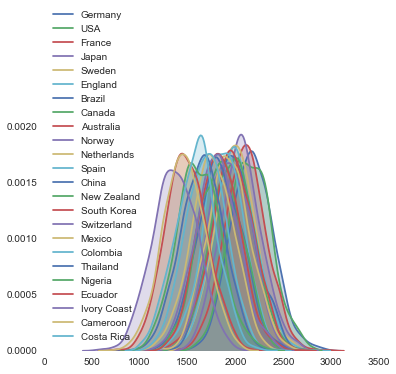

In [3]:
import scipy.stats as stats
import seaborn as sns
%matplotlib inline

for i in range(len(df)):        
    normdist = stats.norm(df.fifascore[i], 220)
    sns.kdeplot(normdist.rvs(1000), shade=True, label=df.team[i])

In [4]:
# http://stackoverflow.com/questions/30606566/generate-pairings-within-world-cup-tournament-groups
import itertools

# pd.DataFrame({grp: tuple(itertools.combinations(team, 2)) for grp, team in df.groupby('group')['team']})

matchlist = {}

for g,t in df.groupby('group')['team']:
    teamlist = t.tolist() # convert from pandas Series to Python list
    games = [match for match in itertools.combinations(teamlist, 2)]
    matchlist[g] = games
    
matchlist

{'A': [('Canada', 'Netherlands'),
  ('Canada', 'China'),
  ('Canada', 'New Zealand'),
  ('Netherlands', 'China'),
  ('Netherlands', 'New Zealand'),
  ('China', 'New Zealand')],
 'B': [('Germany', 'Norway'),
  ('Germany', 'Thailand'),
  ('Germany', 'Ivory Coast'),
  ('Norway', 'Thailand'),
  ('Norway', 'Ivory Coast'),
  ('Thailand', 'Ivory Coast')],
 'C': [('Japan', 'Switzerland'),
  ('Japan', 'Ecuador'),
  ('Japan', 'Cameroon'),
  ('Switzerland', 'Ecuador'),
  ('Switzerland', 'Cameroon'),
  ('Ecuador', 'Cameroon')],
 'D': [('USA', 'Sweden'),
  ('USA', 'Australia'),
  ('USA', 'Nigeria'),
  ('Sweden', 'Australia'),
  ('Sweden', 'Nigeria'),
  ('Australia', 'Nigeria')],
 'E': [('Brazil', 'Spain'),
  ('Brazil', 'South Korea'),
  ('Brazil', 'Costa Rica'),
  ('Spain', 'South Korea'),
  ('Spain', 'Costa Rica'),
  ('South Korea', 'Costa Rica')],
 'F': [('France', 'England'),
  ('France', 'Mexico'),
  ('France', 'Colombia'),
  ('England', 'Mexico'),
  ('England', 'Colombia'),
  ('Mexico', 'Colom

In [5]:
matchdf = pd.DataFrame.from_dict(matchlist, orient='columns')
matchdf = pd.melt(matchdf, var_name='group')
matchdf['team1'] = matchdf.value.map(lambda x: x[0])
matchdf['team2'] = matchdf.value.map(lambda x: x[1])
matchdf.drop('value', axis=1, inplace=True)
matchdf

,group,team1,team2
0,A,Canada,Netherlands
1,A,Canada,China
2,A,Canada,New Zealand
3,A,Netherlands,China
4,A,Netherlands,New Zealand
5,A,China,New Zealand
6,B,Germany,Norway
7,B,Germany,Thailand
8,B,Germany,Ivory Coast
9,B,Norway,Thailand


In [23]:
def score_comparator(A, B, method):
  # 2 pts per win, 1 pt per draw per our rules
    import numpy as np
    tscore = np.sqrt(np.power(2*df[method].std(),2))
    if abs(A-B) < tscore:
        return 1,1
    elif A - B >= tscore:
        return 2,0
    else:
        return 0,2

def montecarlo(method, simulations):
    """
    Args:
        method: ['fifascore', 'ftescore']
        simulations: An int for number of trials
        
    Returns:
        A tuple (x,y) where x is a DataFrame of scores and y is a DataFrame of team rank (max method) in each trial
    """
    scorelist = []
    rklist=[]
    for i in range(simulations):
        matchdf['mean1'] = matchdf.team1.map(df[method]) # bring over the mean
        matchdf['mean2'] = matchdf.team2.map(df[method])
        matchdf['draw1'] = matchdf.mean1.map(lambda x: stats.norm(x, df[method].std()).rvs(1)[0]) # random pull from normdist
        matchdf['draw2'] = matchdf.mean2.map(lambda x: stats.norm(x, df[method].std()).rvs(1)[0])
        matchdf['score1'] = matchdf.apply(lambda x: score_comparator(x.draw1, x.draw2, method)[0], axis=1) # points for team1
        matchdf['score2'] = matchdf.apply(lambda x: score_comparator(x.draw1, x.draw2, method)[1], axis=1)
        scores = pd.concat([matchdf.groupby('team1').sum().score1, matchdf.groupby('team2').sum().score2],
                          axis=1, join='outer')
        scores.fillna(0, inplace=True)
        scores = scores.score1 + scores.score2
        scorelist.append(scores)
        
        ranks = scores.rank(method='max')
        rklist.append(ranks)
        
    score_trials = pd.concat(scorelist, axis=1)
    
    rank_trials = pd.concat(rklist, axis=1)
    return score_trials, rank_trials
    
# %timeit montecarlo('fifascore', 100);
# %timeit montecarlo('ftescore', 100);

In [24]:
fifa_score, fifa_rk = montecarlo('fifascore', 100)
fte_score, fte_rk = montecarlo('ftescore', 100)

In [26]:
result = pd.concat([fifa_score.mean(axis=1), fifa_rk.mean(axis=1),
                    fte_score.mean(axis=1), fte_rk.mean(axis=1)], axis=1)              
result.columns = ['fifascore', 'fifark', 'ftescore', 'fterk']
result.sort('fterk')

,fifascore,fifark,ftescore,fterk
Ecuador,2.02,9.17,1.08,4.04
Thailand,2.39,11.79,1.37,4.92
Costa Rica,2.05,9.43,1.72,7.15
Ivory Coast,1.21,4.62,2.30,10.87
Colombia,2.26,10.86,2.28,11.08
Nigeria,1.66,7.67,2.39,11.51
Mexico,2.42,12.14,2.41,12.03
New Zealand,2.73,14.18,2.68,13.51
Cameroon,1.86,8.02,2.84,14.73
Australia,3.22,17.12,2.90,14.98
